#Import library

In [1]:
from glob import glob
import numpy as np
import re
import os
import cv2
from keras.utils import img_to_array
import tensorflow as tf
from keras.layers import *
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy, MeanAbsoluteError
from matplotlib import pyplot as plt
from IPython.display import clear_output


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Prepare dataset

* In this project, I use the Landscape Images dataset for train and test. The dataset is available on kaggle. [Download](https://www.kaggle.com/code/theblackmamba31/pix2pix-gan-coloring-images/input).
* Dataset include 7129 pairs of color and grayscale image, but in this repo I only use 500 pairs because of RAM limit.

In [3]:
!unzip "/content/gdrive/MyDrive/P2P_ImgColorizer/landscape_Images.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/landscape_Images/gray/2914.jpg  
  inflating: /content/landscape_Images/gray/2915.jpg  
  inflating: /content/landscape_Images/gray/2916.jpg  
  inflating: /content/landscape_Images/gray/2917.jpg  
  inflating: /content/landscape_Images/gray/2918.jpg  
  inflating: /content/landscape_Images/gray/2919.jpg  
  inflating: /content/landscape_Images/gray/292.jpg  
  inflating: /content/landscape_Images/gray/2920.jpg  
  inflating: /content/landscape_Images/gray/2921.jpg  
  inflating: /content/landscape_Images/gray/2922.jpg  
  inflating: /content/landscape_Images/gray/2923.jpg  
  inflating: /content/landscape_Images/gray/2924.jpg  
  inflating: /content/landscape_Images/gray/2925.jpg  
  inflating: /content/landscape_Images/gray/2926.jpg  
  inflating: /content/landscape_Images/gray/2927.jpg  
  inflating: /content/landscape_Images/gray/2928.jpg  
  inflating: /content/landscape_Images/gray/2929.jpg  
  inflating: /c

In [4]:
ydata_path = '/content/landscape_Images/color/'
xdata_path = '/content/landscape_Images/gray/'

In [5]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [6]:
#helper function for loading data from folder and store in an array
def load_imgs(folder_path, file_list, lim = 500):
    data = []
    for i in file_list:
        if i == (str(lim)+'.jpg'):
            break
        else:
            img = cv2.imread(folder_path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (256, 256))
            img = img.astype('float32') / 255.0
            data.append(img_to_array(img))

    return np.array(data)

Store images array in a tf tensor, split train/test

In [7]:
files_list = os.listdir(xdata_path)

limit = 2000
split_size = int(0.8*limit)

xdata = load_imgs(xdata_path, files_list, limit)
ydata = load_imgs(ydata_path, files_list, limit)

color_dataset=tf.data.Dataset.from_tensor_slices(ydata[:split_size]).batch(25)
gray_dataset=tf.data.Dataset.from_tensor_slices(xdata[:split_size]).batch(25)

color_dataset_t=tf.data.Dataset.from_tensor_slices(ydata[split_size:limit]).batch(5)
gray_dataset_t=tf.data.Dataset.from_tensor_slices(xdata[split_size:limit]).batch(5)

In [8]:
train_dataset = tf.data.Dataset.zip((gray_dataset, color_dataset))
test_dataset = tf.data.Dataset.zip((gray_dataset_t, color_dataset_t))

#Define Model

The architecture of the network will contain:

* A generator with a U-Net-based architecture.
* A discriminator represented by a convolutional PatchGAN classifier.

This implemetation is based on [this tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix)

In [9]:
def downsample(filters, size, apply_batchnorm=True):

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer='he_normal', use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):


  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer='he_normal',
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [10]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

#Loss Function

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

#Train

In [13]:
generator = Generator()
discriminator = Discriminator()

In [14]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
  print('Epoch%d: GLoss: %d -- Dloss %d' % (epoch,gen_total_loss, disc_loss))

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  if (epoch + 1) % 50 == 0:
    generator.save('/content/gdrive/MyDrive/P2P_ImgColorizer/gen_ws/model%d.hdf5' % epoch+1)

In [15]:
def fit(train_ds, epochs,):
  for epoch in range(epochs):
    # Train
    for n, (input_image, target) in train_ds.enumerate():

      train_step(input_image, target, epoch)

In [16]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()


In [17]:
fit(train_dataset, epochs = 10)

Epoch0: GLoss: 49 -- Dloss 1


Epoch0: GLoss: 43 -- Dloss 3
Epoch0: GLoss: 44 -- Dloss 1
Epoch0: GLoss: 39 -- Dloss 1
Epoch0: GLoss: 32 -- Dloss 1
Epoch0: GLoss: 32 -- Dloss 1
Epoch0: GLoss: 26 -- Dloss 1
Epoch0: GLoss: 26 -- Dloss 1
Epoch0: GLoss: 22 -- Dloss 1
Epoch0: GLoss: 19 -- Dloss 1
Epoch0: GLoss: 18 -- Dloss 1
Epoch0: GLoss: 16 -- Dloss 1
Epoch0: GLoss: 14 -- Dloss 1
Epoch0: GLoss: 12 -- Dloss 1
Epoch0: GLoss: 12 -- Dloss 1
Epoch0: GLoss: 11 -- Dloss 1
Epoch0: GLoss: 11 -- Dloss 1
Epoch0: GLoss: 11 -- Dloss 1
Epoch0: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 9 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epoch1: GLoss: 8 -- Dloss 1
Epo

In [19]:
checkpoint_folder ='/content/gdrive/MyDrive/P2P_ImgColorizer/checkpoint'
checkpoint_prefix = os.path.join(checkpoint_folder, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))

#Test with other image

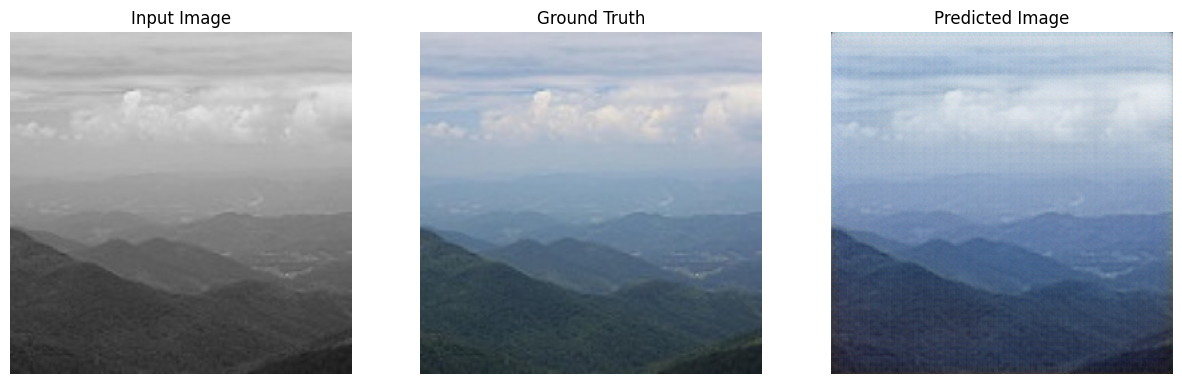

In [22]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)